# `crowd-hpo`: Analysis of Results

This notebook allows us to query tabular results via [`mlflow`](https://mlflow.org/). As a prerequisite, the experiments have to be performed in a first step. If this is the case, we can load the results for the different tables in the accompanied article. Update
- `MLRUNS_PATH` to the path, where the results are stored according to your config file [`experiment.yaml`](../conf/experiment.yaml), 
- `FIGURES_PATH` to the path, where any figures are to be saved,
- `CACHE_PATH` to the path, where any intermediate results loaded via mlfow are to be cached,
- `SHOW_LATEX` to `True`, if the full tabluar results are to be shown as LaTeX code,
- `SHOW_INDIVIDUAL_SCORES` to `True`, if the individual hyperparameters for the ground truth training are to be shown.

In [1]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.colors import LinearSegmentedColormap
from typing import Optional
from hydra.utils import to_absolute_path
from mlflow import set_tracking_uri, get_experiment_by_name, search_runs
from scipy.stats import percentileofscore, kendalltau, spearmanr


# TODO: Adjust global constants as needed.
MLRUNS_PATH = "/mnt/work/mherde/maml/crowd_hpo/"
FIGURES_PATH = "/mnt/home/mherde/projects/github/multi-annotator-machine-learning/figures/"
CACHE_PATH = "/mnt/home/mherde/projects/github/multi-annotator-machine-learning/empirical_evaluation/python_scripts/results_hpo_backup"
SHOW_LATEX = False
SHOW_INDIVIDUAL_SCORES = False

# Filter meaningless warnings.
warnings.filterwarnings("ignore")

# Define global color setings.
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = [
    (0.0, (0, 128/255, 128/255)),   
    (0.5, (1.0, 1.0, 1.0)),           
    (1.0, (127/255, 0, 127/255)), 
]
custom_cmap = LinearSegmentedColormap.from_list("DivergingTealPurple", colors)

# Increase maximum number of displayed rows.
pd.set_option("display.max_rows", 1000)

# Define global constants for the visualization of results.
UPDATE_COLUMNS = {
    "params.data.optimizer.gt_params.lr": "gt_lr",
    "params.data.optimizer.gt_params.weight_decay": "gt_wd",
    "params.data.optimizer.ap_params.lr": "ap_lr",
    "params.data.optimizer.ap_params.weight_decay": "ap_wd",
    "params.data.train_batch_size": "bs",
    "params.data.max_epochs": "me",
    "params.data.lr_scheduler.params.T_max": "T_max",
    "params.architecture.params.dropout_rate": "dr",
    "params.classifier.params.lmbda": "lmbda",
    "params.classifier.params.eta": "eta",
    "params.classifier.params.alpha": "alpha",
    "params.classifier.params.beta": "beta",
    "params.classifier.embed_size": "dim",
    "params.classifier.params.epsilon": "epsilon",
}
INV_UPDATE_COLUMNS = {v: k for k, v in UPDATE_COLUMNS.items()}
APPROACHES = [
    "ground-truth",
    "majority-vote",
    "dawid-skene",
    "crowd-layer",
    "trace-reg",
    "conal",
    "union-net-a",
    "union-net-b",
    "geo-reg-w",
    "geo-reg-f",
    "madl",
    "crowd-ar",
    "annot-mix",
    "coin-net",
]
DATASETS = []
for v in ["worst-1", "worst-2", "worst-var", "rand-1", "rand-2", "rand-var", "full"]:
    DATASETS.extend(
        [
        f"music_genres_{v}",
        f"label_me_{v}",
        f"dopanim_{v}",
        f"reuters_{v}",
        f"spc_{v}",
        ]
    )
    
LOSS_FUNC = "zero_one_loss"

def process_df(df, clf_col='clf', agg_col='agg'):
    """
    Process a DataFrame by combining classifier and aggregator columns, cleaning specific substrings, 
    dropping the aggregator column, and reordering columns.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least the columns specified by `clf_col` and `agg_col`.
    clf_col : str, optional
        The name of the classifier column. Default is 'clf'.
    agg_col : str, optional
        The name of the aggregator column. Default is 'agg'.

    Returns
    -------
    pandas.DataFrame
        The processed DataFrame with a combined column (named after `clf_col`) placed at the beginning, 
        with the original `agg_col` column removed and specific substrings ('aggregate_' and '_None') replaced 
        with empty strings.
    """
    # Reorder columns so that the combined column comes first
    cols = [clf_col] + [col for col in df.columns if col != clf_col]
    return df[cols]

def evaluate(
    mlruns_path: str,
    experiment_name: str,
    update_columns: dict = None,
    perf_type: str = "gt",
    version: str = "test",
    metric: str = "acc",
    epoch: str = "best",
    loss_func: str = "zero_one_loss",
    print_number_of_runs: bool = False,
    cache_path: Optional[str] = None,
):
    """
    Queries the evaluation results via mlflow.

    Parameters
    ----------
    mlruns_path : str
        Path to the results saved via mlflow.
    experiment_name : str
        Name of the mlflow experiment.
    update_columns : dict, default=None
        Optional dictionary of columns to be included in the output table.
        If None, the global UPDATE_COLUMNS is used.
    perf_type : str, default="gt"
        'gt' for ground-truth estimates or 'ap' for annotator performance estimates.
    version : str, default="test"
        One of 'train', 'valid', or 'test' for different data subsets.
    metric : str, default="acc"
        Performance metric: 'acc', 'brier_score', or 'tce'.
    epoch : str, default="best"
        Either 'last' or 'best' epoch.
    print_number_of_runs : bool, default=False
        Whether to print the count of runs per classifier.
    cache_path : Optional[str], default=None
        If provided, results are cached/read from the given path.

    Returns
    -------
    runs: pd.DataFrame or None
        Table of results or None if no experiment/runs found.
    """
    runs = None
    
    # Use the provided update_columns or fall back to the default global constant.
    if update_columns is None:
        update_columns = UPDATE_COLUMNS.copy()
    
    # Attempt to load from cache if available.
    if cache_path:
        cache_file = os.path.join(cache_path, f"{experiment_name}.csv")
        if os.path.isfile(cache_file):
            runs = pd.read_csv(cache_file)
            if "hyperparameter_search" in experiment_name:
                runs = runs.append(pd.read_csv(cache_file.replace("hyperparameter_search", "default")))
    
    if runs is None:
        # Set mlflow tracking URI.
        abs_mlruns_path = to_absolute_path(mlruns_path)
        set_tracking_uri(uri=f"file://{abs_mlruns_path}")

        exp = get_experiment_by_name(experiment_name)
        if exp is None:
            return None

        query = "status = 'FINISHED'"
    
        runs = search_runs(experiment_ids=exp.experiment_id, filter_string=query, output_format="pandas")
        if runs.empty:
            return None
        if cache_path:
            try:
                runs.to_csv(cache_file, index=False)
            except Exception as e:
                print(f"Warning: Unable to cache results due to error: {e}")
                
    # Base column renaming.
    rename_columns = {
        "params.data.class_definition._target_": "data",
        "params.classifier.name": "clf",
        "params.classifier.aggregation_method": "agg",
    }
    # Update renaming mapping if provided columns exist in runs.
    for col, new_name in update_columns.items():
        if col in runs.columns:
            rename_columns[col] = new_name

    # Build aggregation dictionary.
    agg_dict = {
        f"metrics.{perf_type}_true_{loss_func}_{epoch}_test": ["mean", "std"],
        "params.seed": ["sum"],
    }
    bayes_columns = []
    for col in runs.columns:
        if col.startswith("metrics.") and col.endswith("_valid") and "bayes" not in col:
            agg_dict[col] = ["mean", "std"]

    # Drop duplicates using selected columns.
    # Note: Ensure that 'params.data.class_definition.realistic_split' exists in runs.
    dup_keys = list(rename_columns.keys()) + ["params.seed", "params.data.class_definition.realistic_split"]
    runs = runs.drop_duplicates(subset=dup_keys)#.fillna(np.inf)
    
    if print_number_of_runs:
        # Actually print the value counts.
        print(runs["params.classifier.name"].value_counts().sum())

    runs = runs.sort_values(by="params.seed")
    runs = runs.groupby(list(rename_columns.keys()), as_index=False, dropna=False).agg(agg_dict, skipna=False)

    # Flatten multi-index columns if necessary.
    if isinstance(runs.columns, pd.MultiIndex):
        runs.columns = ["".join(map(str, col)).strip() for col in runs.columns.values]

    # Round 'metrics' columns for accuracy if they exist.
    for col in runs.columns:
        if col.startswith("metrics") and "zero_one_loss" in col:
            runs[col] = np.round(runs[col] * 100, 3)

    # Add an extra column mapping.
    rename_columns["params.seedsum"] = "n_runs"

    # Build a combined renaming mapping for any remaining columns.
    additional_rename = {
        col: col.replace("mean", "")
        .replace("max", "")
        .replace("std", "_std")
        .replace("-", "_")
        .replace("metrics.", "")
        for col in runs.columns
        if col not in rename_columns
    }
    # Merge both dictionaries. (Note: The "|" operator requires Python 3.9+)
    full_rename = rename_columns | additional_rename
    runs = runs.rename(columns=full_rename)
    return runs

## Full Tabular Results

Print the tabular results across all dataset variants, *learning from crowds* (LFC) approaches, and *hyperparameter* (HPS) selection criteria.

In [2]:
df_dict = {}
approach_rankings = None
metric_rankings = None
for ds in DATASETS:
    print(ds)
    results_df_dict = {}
    for experiment_type in ["hyperparameter_search", "default",  f"default_data"]:
        exp_name = f"{experiment_type}_{ds}"
        
        # Load results as as dataframe.
        runs_df = evaluate(
            mlruns_path=os.path.join(MLRUNS_PATH, exp_name),
            experiment_name=exp_name,
            update_columns=UPDATE_COLUMNS,
            perf_type="class",
            version="valid",
            epoch="full",
            loss_func=LOSS_FUNC,
            cache_path=CACHE_PATH,
        )
        if runs_df is None:
            break

        # Preprocess columns.
        df = runs_df.drop(columns=["data"])
        df['clf'] = df['clf'].astype(str) + '-' + df['agg'].astype(str)
        df.drop(columns=['agg'], inplace=True)

        # Identify '_valid' columns & rank them within each group
        target_col = f"class_true_{LOSS_FUNC}_full_test"
        group_cols = ["clf"]
        valid_cols = [c for c in df.columns if c.endswith("valid")]

        if SHOW_INDIVIDUAL_SCORES:

            # Identify non-valid and group columns
            other_cols = [col for col in df.columns if not col.endswith("valid") and col not in group_cols]

            # Function that, for each group, returns rows corresponding 
            # to the max values for each "valid" column.
            def get_max_rows(grp):
                d = {}
                for col in valid_cols:
                    idx = grp[col].idxmin()
                    if not np.isnan(idx):
                        d[col] = grp.loc[idx, other_cols]
                return pd.DataFrame(d).T

            # Apply to each group
            df_max = df.groupby(group_cols).apply(get_max_rows)

            # df_max now has a multi-index with the group keys + the valid column name
            # If you want a flat DataFrame, reset the index and rename columns
            df_max = df_max.reset_index()
            df_max.columns = group_cols + ["valid_col"] + other_cols
            df_max = df_max.sort_values(by=["clf", f"class_true_{LOSS_FUNC}_full_test"])
            df_max["rank"] = df_max.groupby("clf")[f"class_true_{LOSS_FUNC}_full_test"].rank(
                ascending=True, pct=True, method="average"
            )
            df_max = df_max[(df_max["clf"] == "aggregate-ground-truth") & (df_max["valid_col"] == f"class_true_{LOSS_FUNC}_cv_valid")]
            df_max = df_max.rename(columns=INV_UPDATE_COLUMNS)
            drop_col = [c for c in df_max.columns if not "params" in c]
            df_max = df_max.drop(columns=drop_col)
            df_max = df_max.dropna(axis=1)
            #print(df_max.to_markdown(tablefmt="github"))
            df_max = df_max.to_dict("list")
            df_max = {k[7:]: v for k, v in df_max.items() if "alpha" not in k}
            print(df_max)
            print()
            continue


        for col in valid_cols:
            df[col + "_rank"] = df.groupby(group_cols)[col].rank(method="min")

        # Define subsets and compute mean rank per subset.
        subsets = {
            # Lower and upper baseline scores.
            "TRUE": [f"class_true_{LOSS_FUNC}_cv_valid"],
            
            "AEU": [f"class_mv_unif_{LOSS_FUNC}_cv_valid"],
            "AEC": [f"class_mv_unif_weighted_{LOSS_FUNC}_cv_valid"],
            "ALU": [f"class_mv_log_odds_1_{LOSS_FUNC}_cv_valid"],
            "ALC": [f"class_mv_log_odds_1_weighted_{LOSS_FUNC}_cv_valid"],
            
            "CXU": [f"annot_unif_{LOSS_FUNC}_cv_valid"],
            "CEC": [f"annot_unif_weighted_{LOSS_FUNC}_cv_valid"],
            "CLC": [f"annot_log_odds_1_weighted_{LOSS_FUNC}_cv_valid"],
 
            "ENS": [
                f"class_mv_unif_{LOSS_FUNC}_cv_valid",
                f"class_mv_unif_weighted_{LOSS_FUNC}_cv_valid",
                f"class_mv_log_odds_1_{LOSS_FUNC}_cv_valid",
                f"class_mv_log_odds_1_weighted_{LOSS_FUNC}_cv_valid",
                
                f"annot_unif_{LOSS_FUNC}_cv_valid",
                f"annot_unif_weighted_{LOSS_FUNC}_cv_valid",
                f"annot_log_odds_1_weighted_{LOSS_FUNC}_cv_valid",
            ],
        }
        for subset_name, subset_cols in subsets.items():
            rank_cols = [c + "_rank" for c in subset_cols]
            try:
                df[f"{subset_name}_mean_rank"] = df[rank_cols].mean(axis=1, skipna=True)
            except:
                df[f"{subset_name}_mean_rank"] = 100.0
            if len(subset_cols) > 1:
                try:
                    # Prefer HPCs with low standard deviations in case of ties.
                    df[f"{subset_name}_mean_rank"] -= 0.001 * df[rank_cols].std(axis=1, skipna=True)
                except:
                    pass
                
        # Start with a DataFrame of unique group columns.
        results_df_dict[experiment_type] = {
            "mean": df.drop_duplicates(group_cols)[group_cols].sort_values(group_cols).reset_index(drop=True)
        }
        results_df_dict[experiment_type]["std"] = results_df_dict[experiment_type]["mean"].copy()

        # Loop over subsets to find best row -> then attach the 'target'.        
        for subset_name in subsets:
            mean_rank_col = f"{subset_name}_mean_rank"
            best_idx = df.groupby(group_cols)[mean_rank_col].idxmin().dropna()

            # Extract columns for merging, rename 'target' -> subset-specific
            best_for_subset = df.loc[best_idx, group_cols + [target_col]].copy()
            best_for_subset.rename(columns={target_col: f"{subset_name}_target"}, inplace=True)
            results_df_dict[experiment_type]["mean"] = results_df_dict[experiment_type]["mean"].merge(best_for_subset, on=group_cols, how="left")

            best_for_subset = df.loc[best_idx, group_cols + [target_col + "_std"]].copy()
            best_for_subset.rename(columns={target_col + "_std": f"{subset_name}_target"}, inplace=True)
            results_df_dict[experiment_type]["std"] = results_df_dict[experiment_type]["std"].merge(best_for_subset, on=group_cols, how="left")

            
        # Reformat resulting data frames.
        for k in results_df_dict[experiment_type].keys():
            results_df_dict[experiment_type][k].columns = [f"{c.replace('_', '-').replace('-target', '')}" for c in results_df_dict[experiment_type][k].columns]
            results_df_dict[experiment_type][k]['clf'] = results_df_dict[experiment_type][k]['clf'].replace({"aggregate-": "", "-None": "", "_": "-"}, regex=True)
            results_df_dict[experiment_type][k]['sort_key'] = results_df_dict[experiment_type][k]['clf'].apply(lambda x: APPROACHES.index(x))
            results_df_dict[experiment_type][k] = results_df_dict[experiment_type][k].sort_values('sort_key').drop(columns='sort_key')
            results_df_dict[experiment_type][k] = results_df_dict[experiment_type][k].set_index(["clf"])
    if SHOW_INDIVIDUAL_SCORES:
        continue
    perf_cols = ["DEF", "DEF-DATA"] + list(subsets.keys())
    perf_cols[0] = "TRUE"
    perf_cols[2] = "DEF"
    results_df_dict["hyperparameter_search"]["mean"]["DEF"] = results_df_dict["default"]["mean"]["TRUE"].values
    results_df_dict["hyperparameter_search"]["std"]["DEF"] = results_df_dict["default"]["std"]["TRUE"].values
    results_df_dict["hyperparameter_search"]["mean"]["DEF-DATA"] = results_df_dict[f"default_data"]["mean"]["TRUE"].values
    results_df_dict["hyperparameter_search"]["std"]["DEF-DATA"] = results_df_dict[f"default_data"]["std"]["TRUE"].values
    results_df_dict = {"mean": results_df_dict["hyperparameter_search"]["mean"].reindex(perf_cols, axis=1), "std": results_df_dict["hyperparameter_search"]["std"].reindex(perf_cols, axis=1)}
    for stat in ["mean", "std"]:
        results_df_dict[stat].loc["ground-truth"]["DEF-DATA"] = results_df_dict[stat].loc["ground-truth"]["TRUE"]
    df_dict[ds] = results_df_dict
    
    # Print results as markdown.
    df_markdown = results_df_dict["mean"].applymap(lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x) + " ± " + results_df_dict["std"].applymap(lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x)
    print(df_markdown.to_markdown(tablefmt="github", floatfmt=".4f"))

    if SHOW_LATEX:
        df_latex = results_df_dict["mean"].applymap(lambda x: f"${x:.2f}" if isinstance(x, (float, int)) else x) + "_{\pm " + results_df_dict["std"].applymap(lambda x: f"{x:.2f}" + "}$" if isinstance(x, (float, int)) else x)
        df_latex.index = df_latex.index.map(lambda x: f"\\texttt{{{x}}}")
        df_latex = df_latex.replace("$nan_{\pm nan}$", "--")

        # Get the underlying DataFrames for means and standard deviations
        mean_df = results_df_dict["mean"]
        std_df = results_df_dict["std"]

        # Compute the minimum value for each column (all columns)
        col_min = mean_df[1:].min()

        # Compute the minimum for each row only considering columns starting from the third column
        row_min = mean_df.iloc[:, 1:].min(axis=1)

        # Create a copy to store our LaTeX formatted strings
        df_latex = mean_df.copy()

        # Iterate over every cell to apply the formatting
        for i in mean_df.index:
            for j in mean_df.columns:
                m_val = mean_df.loc[i, j]
                s_val = std_df.loc[i, j]
                if isinstance(m_val, (int, float)):
                    # Format the mean value with two decimals
                    formatted_mean = f"{m_val:.2f}"
                    # Bold if it is the minimum in its column
                    is_bold = m_val == col_min[j]
                    # Underline only if this column is not one of the first two
                    col_index = mean_df.columns.get_loc(j)
                    is_underline = (col_index >= 1) and (m_val == row_min[i]) and i != "ground-truth"

                    # Apply nested formatting if both conditions hold
                    if is_bold and is_underline:
                        formatted_mean = f"\\underline{{\\textBF{{{formatted_mean}}}}}"
                    elif is_bold:
                        formatted_mean = f"\\textBF{{{formatted_mean}}}"
                    elif is_underline:
                        formatted_mean = f"\\underline{{{formatted_mean}}}"

                    # Format the standard deviation value
                    if isinstance(s_val, (int, float)):
                        formatted_std = f"{s_val:.2f}" if s_val < 10 else f"{s_val:.1f}"
                    else:
                        formatted_std = s_val
                    # Combine into one LaTeX math mode string
                    df_latex.loc[i, j] = f"${formatted_mean}_{{\\pm {formatted_std}}}$"
                else:
                    df_latex.loc[i, j] = m_val

        # Format the index using typewriter font
        approaches_replace = {
            "ground-truth": "gt",
            "majority-vote": "mv",
            "dawid-skene": "ds",
            "crowd-layer": "cl",
            "trace-reg": "trace",
            "conal": "conal",
            "union-net-a": "union-a",
            "union-net-b": "union-b",
            "geo-reg-w": "geo-w",
            "geo-reg-f": "geo-f",
            "madl": "madl",
            "crowd-ar": "crowd-ar",
            "annot-mix": "annot-mix",
            "coin-net": "coin",
            
        }
        df_latex.index = df_latex.index.map(
            lambda x: f"\\texttt{{{approaches_replace[x]}}}"
        )

        # Replace any problematic nan strings with a placeholder
        df_latex = df_latex.replace("$nan_{\\pm nan}$", "N/A")

        # Print the LaTeX output from the styled DataFrame
        print(df_latex.style.to_latex())
        
    # For each performance metric, compute the rank.
    approach_rankings = {metric: {} for metric in perf_cols} if approach_rankings is None else approach_rankings
    for metric in perf_cols:
        results_df_dict["mean"][f'{metric}_rank'] = results_df_dict["mean"][metric].rank(method='average', pct=False)-1
        results_df_dict["mean"][f'{metric}_rank'] /= results_df_dict["mean"][metric].rank(method='average', pct=False).max()
        
    # For each metric, rank the approaches.
    for key, row in results_df_dict["mean"].iterrows():
        for metric in perf_cols:
            if key not in approach_rankings[metric]:
                approach_rankings[metric][key] = []
            approach_rankings[metric][key].append(row[f'{metric}_rank'])

    # For each approach, rank its performance metrics.
    metric_rankings = {} if metric_rankings is None else metric_rankings
    grouped = results_df_dict["mean"].groupby(group_cols)[perf_cols].mean().reset_index()
    grouped['sort_key'] = grouped['clf'].apply(lambda x: APPROACHES.index(x))
    grouped = grouped.sort_values('sort_key').drop(columns='sort_key')
    for approach, row in grouped.iterrows():
        approach = row["clf"]
        perf_values = row[perf_cols]
        metric_ranks = perf_values.rank(method='average', pct=False)-1
        metric_ranks /= perf_values.rank(method='average', pct=False).max()
        if approach not in metric_rankings:
            metric_rankings[approach] = {metric: [] for metric in perf_cols}
        for metric in perf_cols:
            metric_rankings[approach][metric].append(metric_ranks[metric])

music_genres_worst-1
| clf           | TRUE         | DEF-DATA     | DEF          | AEU          | AEC          | ALU          | ALC          | CXU          | CEC          | CLC          | ENS          |
|---------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
| ground-truth  | 20.27 ± 0.83 | 20.27 ± 0.83 | 24.60 ± 1.12 | 21.00 ± 1.94 | 21.00 ± 1.94 | nan ± nan    | nan ± nan    | nan ± nan    | nan ± nan    | nan ± nan    | 21.00 ± 1.94 |
| majority-vote | 81.27 ± 1.32 | 86.93 ± 1.30 | 81.47 ± 0.96 | 79.73 ± 1.75 | 79.73 ± 1.75 | nan ± nan    | nan ± nan    | nan ± nan    | nan ± nan    | nan ± nan    | 79.73 ± 1.75 |
| dawid-skene   | 81.27 ± 1.32 | 86.93 ± 1.30 | 81.47 ± 0.96 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 | 79.73 ± 1.75 |
| crowd-layer   | 74.33 ± 4.29 | 85.67 ± 1.93 | 79.73 ± 1.67 | 8

## Default (DEF) Versus Optimized (TRUE) HPCs for LFC Approaches.

Compare the performances of LFC approaches when employing default (DEF) and optimized (TRUE) HPCs for the dataset variant `reuters-full`.

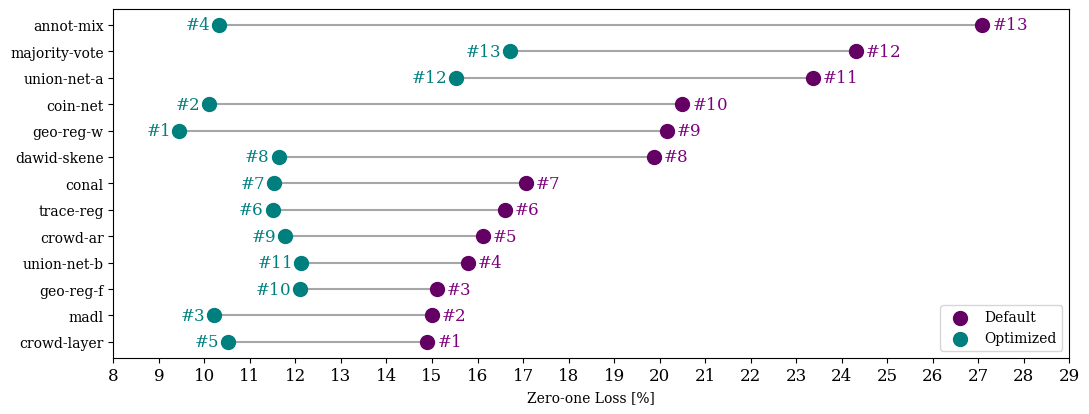

In [3]:
# Simulate performance data for 12 approaches.
np.random.seed(0)
approaches = APPROACHES[1:]

# Values are copied from the reuters-full experiment (cf. table above).
def_performance = np.array([24.32, 19.88, 14.90, 16.61, 17.07, 23.36, 15.79, 20.16, 15.10, 14.99, 16.11, 27.09, 20.50])
opt_performance = np.array([16.71, 11.64, 10.52, 11.50, 11.53, 15.53, 12.13, 09.45, 12.11, 10.22, 11.78, 10.33, 10.11])


# Compute rankings (1=best) based on performance (higher is better).
default_rank = np.argsort(def_performance).argsort() + 1
optimized_rank = np.argsort(opt_performance).argsort() + 1

# Sort approaches by default performance for clearer visualization.
order = np.argsort(def_performance)
approaches_sorted = np.array(approaches)[order]
default_sorted = def_performance[order]
optimized_sorted = opt_performance[order]
default_rank_sorted = default_rank[order]
optimized_rank_sorted = optimized_rank[order]

fig, ax = plt.subplots(figsize=(11, 4.25))

# Plot dumbbell lines for performance gain.
ax.hlines(y=approaches_sorted, xmin=default_sorted, xmax=optimized_sorted, color='gray', alpha=0.7, zorder=-3)

# Annotate each marker with its ranking.
for i, approach in enumerate(approaches_sorted):
    # Annotate the default performance marker with its rank.
    ax.text(default_sorted[i] + 0.2, approaches_sorted[i],
            f'$\\#{default_rank_sorted[i]}$', color=(127/255, 0, 127/255), va='center', ha='left', fontsize=12)
    # Annotate the optimized performance marker with its rank.
    ax.text(optimized_sorted[i] - 0.2, approaches_sorted[i],
            f'$\\#{optimized_rank_sorted[i]}$', color=(0, 127/255, 127/255), va='center', ha='right', fontsize=12)
    
# Plot markers for default and optimized performance.
ax.scatter(default_sorted, approaches_sorted, color=(100/255, 0, 100/255), s=100, label='Default')
ax.scatter(optimized_sorted, approaches_sorted, color=(0, 127/255, 127/255), s=100, label='Optimized')

ax.set_xlabel('Zero-one Loss [%]')
ax.set_xticks(np.arange(8, 30, 1))
ax.set_xticklabels(np.arange(8, 30, 1), fontsize=12)
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "graphical_abstract.pdf"))
plt.show()

## Pairwise Win-rate Matrix for HPS Criteria

Across all datasets and LFC approaches, a cell reports the percentage [$\%$] on which the row criterion selects an HPC outperforming the HPC selected by the column criterion.

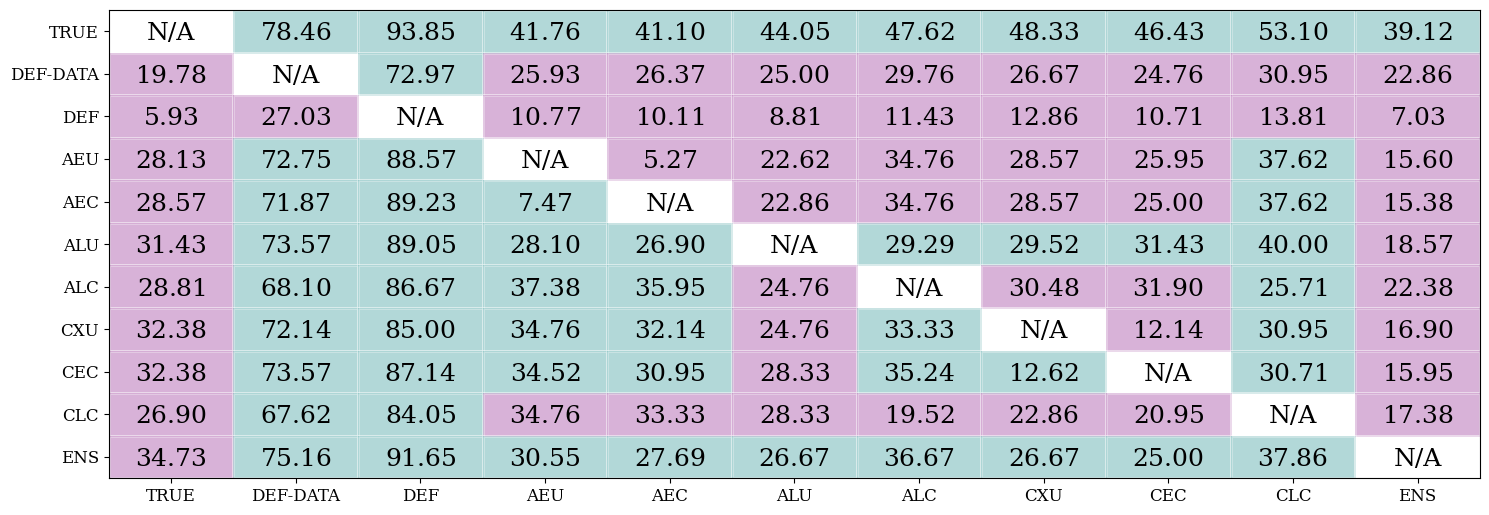

In [4]:
# Initialize DataFrames to hold win counts and total comparisons for each pair (i,j).
win_counts = None
total_counts = None
ordered_criteria = list(subsets.keys())
ordered_criteria.insert(1, "DEF-DATA")
ordered_criteria.insert(2, "DEF")

# Loop over each dataset and each variant (row)
for ds_name, df in df_dict.items():
    df = df["mean"][ordered_criteria][1:]
    if win_counts is None or total_counts is None:
        # Initialize DataFrames to hold win counts and total comparisons for each pair (i,j)
        win_counts = pd.DataFrame(0, index=df.columns, columns=df.columns, dtype=float)
        total_counts = pd.DataFrame(0, index=df.columns, columns=df.columns, dtype=float)
    for idx, row in df.iterrows():
        for i in df.columns:
            for j in df.columns:
                # Only compare if both values are not NaN.
                if pd.notnull(row[i]) and pd.notnull(row[j]):
                    total_counts.loc[i, j] += 1
                    if row[i] < row[j]:
                        win_counts.loc[i, j] += 1

winning_percentage = win_counts / total_counts * 100
winning_diffs = ((winning_percentage.values.T - winning_percentage.values) > 0).astype(float)
np.fill_diagonal(winning_diffs, np.nan)
np.fill_diagonal(winning_percentage.values, np.nan)
fig, ax = plt.subplots(figsize=(15, 5.25))
ax.pcolormesh(winning_diffs, cmap=custom_cmap, vmin=0, vmax=1, alpha=0.3, edgecolors="white", linewidth=2, shading="flat")
ax.set_aspect("auto")
for i in range(winning_percentage.shape[0]):
    for j in range(winning_percentage.shape[1]):
        formatted_text = r'${:.2f}$'.format(winning_percentage.iloc[i, j]).replace("$nan$", "N/A")
        plt.text(j+0.5, i+0.56, formatted_text, ha="center", va="center", color="black", fontsize=18)
ax.set_xticks(np.arange(len(winning_percentage))+0.5, winning_percentage.index.values, fontsize=12) # fontsize=15
ax.set_yticks(np.arange(len(winning_percentage))+0.5, winning_percentage.index.values, fontsize=12) # fontsize=15
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"criteria_winning_matrix_{LOSS_FUNC}.pdf"))
plt.show()

## Pairwise Win-rate matrix for LFC approaches with ENS as HPS Criterion

Across all dataset variants, a cell reports the percentage [$\%$] on which the row approach outperforms the column approach.

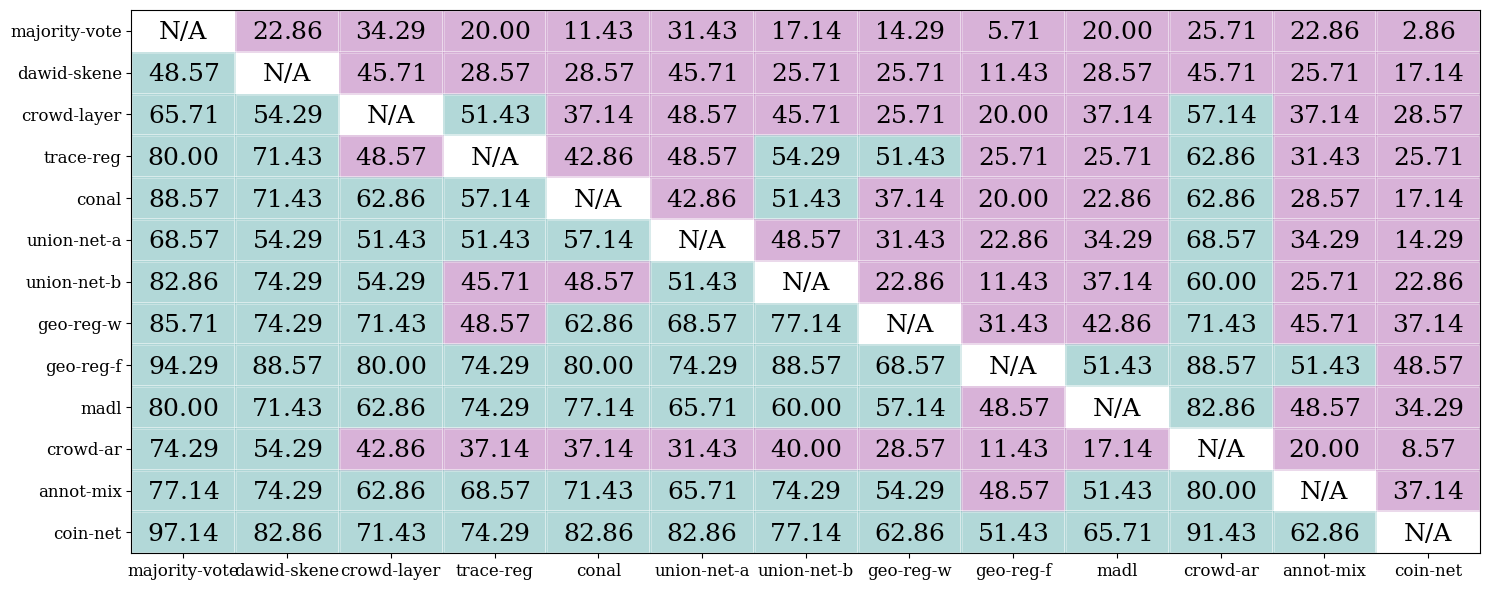

In [5]:
# Initialize DataFrames to hold win counts and total comparisons for each pair (i,j)
win_counts = None
total_counts = None

# Loop over each dataset and each variant (row)
for ds_name, df in df_dict.items():
    df = df["mean"][["ENS"]][1:]
    if win_counts is None or total_counts is None:
        # Initialize DataFrames to hold win counts and total comparisons for each pair (i,j)
        win_counts = pd.DataFrame(0, index=df.index, columns=df.index, dtype=float)
        total_counts = pd.DataFrame(0, index=df.index, columns=df.index, dtype=float)
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if pd.notnull(row_i.values[0]) and pd.notnull(row_j.values[0]):
                total_counts.loc[i, j] += 1
                if row_i.values[0] < row_j.values[0]:
                    win_counts.loc[i, j] += 1

# Compute winning percentage matrix (expressed as a percentage).
winning_percentage = win_counts / total_counts * 100
winning_diffs = ((winning_percentage.values.T - winning_percentage.values) > 0).astype(float)
np.fill_diagonal(winning_diffs, np.nan)
np.fill_diagonal(winning_percentage.values, np.nan)
fig, ax = plt.subplots(figsize=(15, 6))
ax.pcolormesh(winning_diffs, cmap=custom_cmap, vmin=0, vmax=1, alpha=0.3, edgecolors="white", linewidth=2, shading="flat")
ax.set_aspect("auto")
for i in range(winning_percentage.shape[0]):
    for j in range(winning_percentage.shape[1]):
        formatted_text = r'${:.2f}$'.format(winning_percentage.iloc[i, j]).replace("$nan$", "N/A")
        plt.text(j+0.5, i+0.55, formatted_text, ha="center", va="center", color="black", fontsize=18)
ax.set_xticks(np.arange(len(winning_percentage))+0.5, winning_percentage.index.values, fontsize=12) # fontsize=15
ax.set_yticks(np.arange(len(winning_percentage))+0.5, winning_percentage.index.values, fontsize=12) # fontsize=15
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"approaches_winning_matrix_{LOSS_FUNC}.pdf"))
plt.show()

## HPS Criteria's Tabular Results

We report the ranks compared to the other criteria and the zero-one loss reductions (absolute as percentage points [$\%_p$] and relative as percentages [$\%$]) compared to DEF as criterion.

In [6]:
# Specifiy test case, which is either "all" or one of the LFC approaches.
test_approach = "all"
alpha = 0.05
ordered_criteria = list(subsets.keys())
ordered_criteria.insert(1, "DEF-DATA")
ordered_criteria.insert(2, "DEF")

# Combine all datasets into one DataFrame.
df_mean_dict = {k: v["mean"][["DEF", "DEF-DATA"] + list(subsets.keys())] for k, v in df_dict.items()}
data_all = pd.concat(df_mean_dict, names=['dataset', 'variant'])
if test_approach != "all":
    is_approach = [test_approach in idx_tuple[1] for idx_tuple in data_all.index]
    data_all = data_all[is_approach]
if data_all.isnull().any().any():
    data_all = data_all.dropna()
data_all = data_all.reset_index()
data_long = data_all.melt(id_vars=['dataset', 'variant'], var_name='approach', value_name='loss')
data_long['block'] = data_long['dataset'].astype(str) + "_" + data_long['variant'].astype(str)
data_long = data_long[["block", "approach", "loss"]]
data_long['block_id'] = data_long.groupby('block').ngroup()
wide = data_long.pivot(index='block', columns='approach', values='loss')
    
avg_rank = data_long.groupby('block')["loss"].rank(pct=False, method="average").groupby(data_long["approach"]).mean()[ordered_criteria]
sem_rank = data_long.groupby('block')["loss"].rank(pct=False, method="average").groupby(data_long["approach"]).sem()[ordered_criteria]
print("################################")
print("Average of ranks:")
print(avg_rank.round(2))
print("Standard error of average ranks:")
print(sem_rank.round(2))

gains = wide.copy()
gains.iloc[:] = (wide["DEF"].values[:, None] - wide.values)
print("\n################################")
print("Average absolute reductions:")
print(gains[ordered_criteria].mean(axis=0).round(2))
print("Standard error of average absolute reductions:")
print(gains[ordered_criteria].sem(axis=0).round(2))

gains = wide.copy()
gains.iloc[:] = ((wide["DEF"].values[:, None] - wide.values) / wide["DEF"].values[:, None]) * 100
print("\n################################")
print("Average relative reductions:")
print(gains[ordered_criteria].mean(axis=0).round(2))
print("Standard error of average relative reductions:")
print(gains[ordered_criteria].sem(axis=0).round(2))

################################
Average of ranks:
approach
TRUE        4.64
DEF-DATA    7.84
DEF         9.76
AEU         5.66
AEC         5.57
ALU         5.29
ALC         5.60
CXU         5.46
CEC         5.36
CLC         5.91
ENS         4.89
Name: loss, dtype: float64
Standard error of average ranks:
approach
TRUE        0.15
DEF-DATA    0.17
DEF         0.11
AEU         0.11
AEC         0.11
ALU         0.11
ALC         0.13
CXU         0.11
CEC         0.11
CLC         0.13
ENS         0.09
Name: loss, dtype: float64

################################
Average absolute reductions:
approach
TRUE        5.36
DEF-DATA    0.76
DEF         0.00
AEU         4.55
AEC         4.59
ALU         4.73
ALC         4.43
CXU         4.52
CEC         4.57
CLC         4.07
ENS         5.15
dtype: float64
Standard error of average absolute reductions:
approach
TRUE        0.24
DEF-DATA    0.31
DEF         0.00
AEU         0.26
AEC         0.26
ALU         0.26
ALC         0.27
CXU         0.29
CEC 

## LFC Approaches' Tabular Results with ENS as HPS Criterion

We report the ranks compared to the other approaches and the zero-one loss reductions (absolute as percentage points [$\%_p$] and relative as percentages [$\%$]) compared to the approach MV trained with the default (DEF) HPC.

In [7]:
# Specifiy test case, which is either "all" or one of the model selection criteria.
test_approach = "ENS"
ordered_approaches = APPROACHES[1:]

# Combine all datasets into one DataFrame.
rows = []
for ds_name, v in df_dict.items():
    wide = v["mean"][["DEF", "DEF-DATA"] + list(subsets.keys())]
    wide.loc["majority-vote"].fillna(wide.loc["majority-vote"]["AEU"], inplace=True)
    wide = wide.assign(variant=wide.index)              
    wide.loc["majority-vote-def"] = v["mean"]["DEF"].loc["majority-vote"]
    wide.loc["majority-vote-def", "variant"] = "majority-vote-def"
    long = wide.melt(id_vars="variant", var_name="approach", value_name="loss")
    long["dataset"] = ds_name
    rows.append(long)
data_long = pd.concat(rows, ignore_index=True)
data_long = data_long.loc["ground-truth" != data_long["variant"]]
if test_approach != "all":
    is_approach = data_long["approach"] == test_approach
    data_long = data_long[is_approach]

if test_approach != "all":
    data_long["block"] = data_long["dataset"]
else:
    data_long["block"] = data_long["dataset"] + "_" + data_long["approach"]
data_long = data_long.dropna(subset=["loss"])
data_long["block_id"] = data_long.groupby("block").ngroup()
wide = data_long.pivot(index='block', columns='variant', values='loss')

avg_rank = data_long.groupby('block')["loss"].rank(pct=False, method="average").groupby(data_long["variant"]).mean()
std_rank = data_long.groupby('block')["loss"].rank(pct=False, method="average").groupby(data_long["variant"]).sem()
print("################################")
print("Average of ranks:")
print(avg_rank.round(2))
print("Standard error of average ranks:")
print(sem_rank.round(2))

gains = wide.copy()
gains.iloc[:] = (wide["majority-vote-def"].values[:, None] - wide.values)
print("\n################################")
print("Average absolute reductions:")
print(gains[ordered_approaches].mean(axis=0).round(2))
print("Standard error of average absolute reductions:")
print(gains[ordered_approaches].sem(axis=0).round(2))

gains = wide.copy()
gains.iloc[:] = ((wide["majority-vote-def"].values[:, None] - wide.values) / wide["majority-vote-def"].values[:, None]) * 100
print("\n################################")
print("Average relative reductions:")
print(gains[ordered_approaches].mean(axis=0).round(2))
print("Standard error of average relative reductions:")
print(gains[ordered_approaches].sem(axis=0).round(2))

################################
Average of ranks:
variant
annot-mix             5.34
coin-net              3.96
conal                 7.40
crowd-ar              8.97
crowd-layer           7.93
dawid-skene           9.24
geo-reg-f             4.10
geo-reg-w             5.81
madl                  5.39
majority-vote        10.70
majority-vote-def    13.54
trace-reg             7.37
union-net-a           7.60
union-net-b           7.64
Name: loss, dtype: float64
Standard error of average ranks:
approach
TRUE        0.15
DEF-DATA    0.17
DEF         0.11
AEU         0.11
AEC         0.11
ALU         0.11
ALC         0.13
CXU         0.11
CEC         0.11
CLC         0.13
ENS         0.09
Name: loss, dtype: float64

################################
Average absolute reductions:
variant
majority-vote     5.60
dawid-skene       6.05
crowd-layer       8.04
trace-reg         7.81
conal             7.18
union-net-a       7.05
union-net-b       7.42
geo-reg-w         9.70
geo-reg-f        10.05
ma

# Rank Correlation between HPS Ccriteria

Each violin plot shows the distribution of pairwise Kendall $\tau$-$b$ coefficients, visualized as violet dots and obtained from 35 dataset variants when comparing the ranking of LFC approaches with their HPCs selected via a baseline criterion or the ensemble-based criterion.

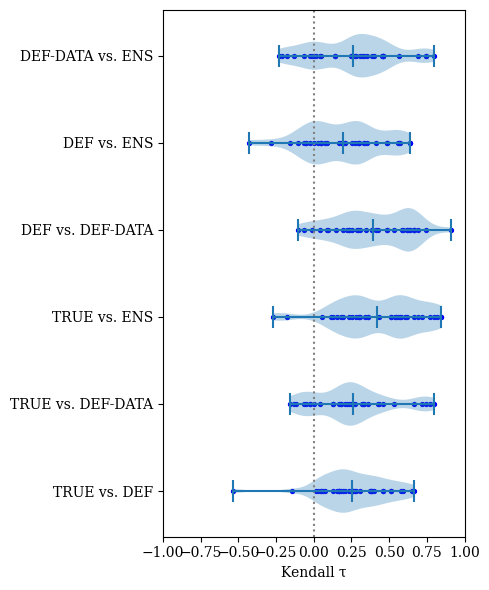

In [8]:
rank_matrices = []
criteria = ["TRUE", "DEF", "DEF-DATA", "ENS"]
for test_approach in criteria:
    ordered_approaches = APPROACHES[1:]

    # Combine all datasets into one DataFrame.
    rows = []
    for ds_name, v in df_dict.items():
        wide = v["mean"][["DEF", "DEF-DATA"] + list(subsets.keys())]
        wide.loc["majority-vote"].fillna(wide.loc["majority-vote"]["AEU"], inplace=True)
        wide = wide.assign(variant=wide.index)
        long = wide.melt(id_vars="variant", var_name="approach",  value_name="loss")
        long["dataset"] = ds_name
        rows.append(long)
    data_long = pd.concat(rows, ignore_index=True)
    data_long = data_long.loc["ground-truth" != data_long["variant"]]
    if test_approach != "all":
        is_approach = data_long["approach"] == test_approach
        data_long = data_long[is_approach]

    if test_approach != "all":
        data_long["block"] = data_long["dataset"]
    else:
        data_long["block"] = data_long["dataset"] + "_" + data_long["approach"]
    data_long = data_long.dropna(subset=["loss"])
    data_long["block_id"] = data_long.groupby("block").ngroup()
    wide = data_long.pivot(index='block', columns='variant', values='loss')
    # Plot ranking values.
    avg_rank = data_long.groupby('block')["loss"].rank(pct=False, method="average")
    rank_matrices.append(wide.rank(pct=False, method="average", axis="columns"))

R = np.stack(rank_matrices, axis=1)
pairs  = list(itertools.combinations(range(len(criteria)), 2))
tau    = np.zeros((35, len(pairs)))      # 35 datasets × 6 pairs
for d in range(35):
    for k, (c1, c2) in enumerate(pairs):
        tau[d, k], _ = kendalltau(R[d, c1], R[d, c2])
    
# Violinplot of coefficients.
plt.figure(figsize=(5, 6))
plt.axvline(0, color='grey', linestyle=':')
for (k,(i,j)) in enumerate(pairs):
    plt.scatter(tau[:, k], np.full_like(tau[:, k], fill_value=k+1), c="blue", s=8)
plt.violinplot(tau, showmeans=True, bw_method=0.3, vert=False)
plt.yticks(range(1, len(pairs)+1), [f"{criteria[i]} vs. {criteria[j]}" for i,j in pairs])
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.xlabel("Kendall τ")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "kendall_violinplot.pdf"))
plt.show()

# Zero–one Loss Reductions of HPS Criteria per LFC Approach

For each LFC approach ($x$-axis), the scatter plot displays the mean and standard error of a criterion's reduction in zero–one loss ($y$-axis) compared to the criterion DEF.

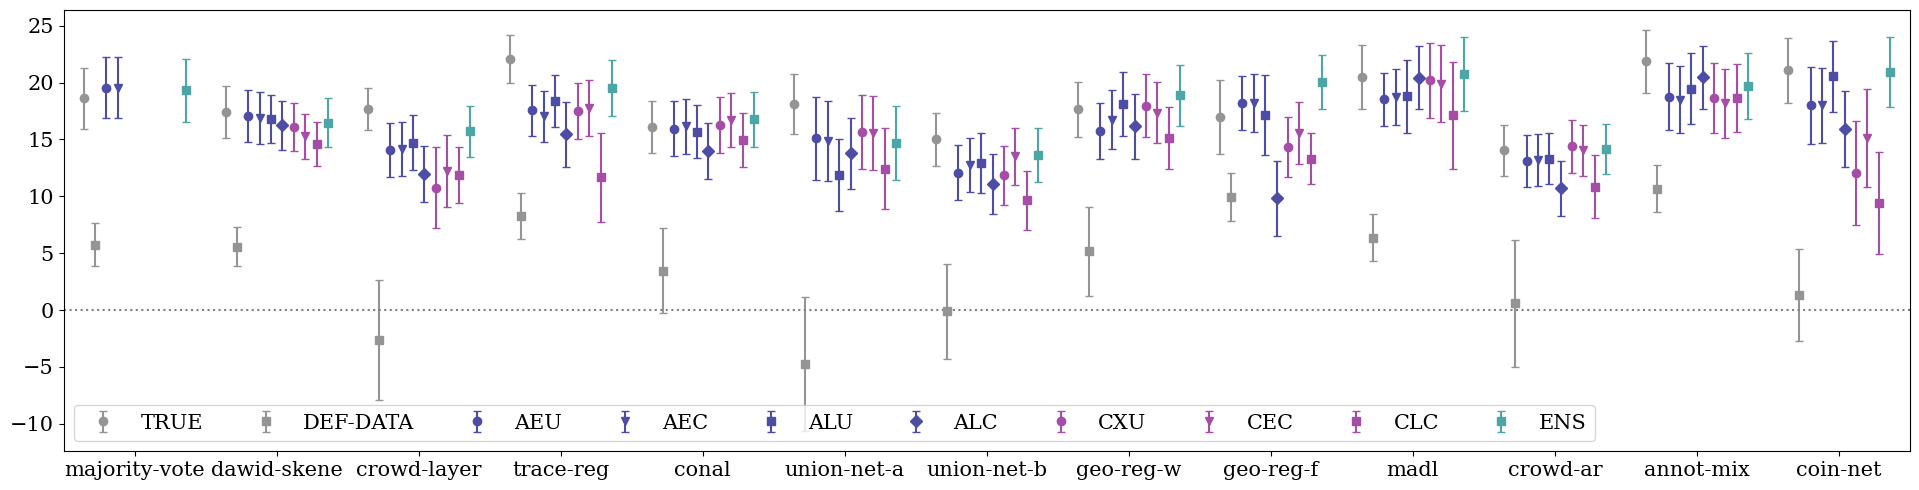

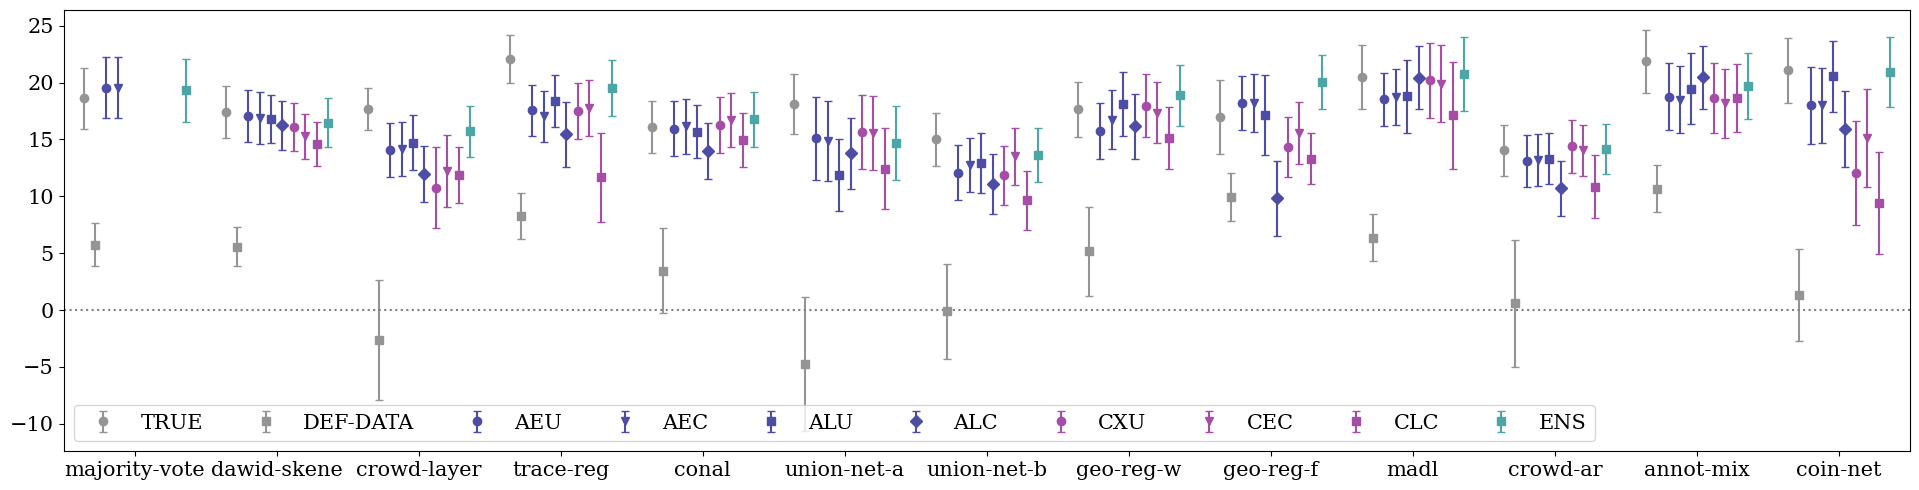

In [9]:
import pandas as pd
import numpy as np

for scatter_type in ["absolute", "relative"]:
    # ------------------------------------------------------------------
    # SETTINGS
    # ------------------------------------------------------------------
    scatter_type = "relative"
    approaches      = list(subsets.keys())
    approaches.insert(1, "DEF-DATA")
    approaches.insert(2, "DEF")
    baseline        = "DEF"
    comp_approaches = [a for a in approaches if a != baseline]

    # ------------------------------------------------------------------
    # 1 · COLLECT GAPS PER GROUP
    # ------------------------------------------------------------------
    abs_by_group = {}   # {group: {approach: [gaps]}}
    rel_by_group = {}   # same for % gaps

    for ds_name, df in df_dict.items():
        # sub: DataFrame whose *rows are groups* and columns are the approaches
        sub = df["mean"][approaches]

        for group_name, row in sub.iterrows():
            base_val = row[baseline]
            if pd.isnull(base_val):
                continue

            # make sure the inner dicts exist
            abs_by_group.setdefault(group_name, {a: [] for a in comp_approaches})
            rel_by_group.setdefault(group_name, {a: [] for a in comp_approaches})

            for a in comp_approaches:
                val = row[a]
                if pd.notnull(val):
                    gap     = base_val - val                      # +ve ⇒ better than DEF
                    gap_pct = (gap / base_val) * 100
                    abs_by_group[group_name][a].append(gap)
                    rel_by_group[group_name][a].append(gap_pct)

    # ------------------------------------------------------------------
    # 2 · BUILD SUMMARY TABLE  (mean ± SD)
    # ------------------------------------------------------------------
    rows = []
    for group in sorted(abs_by_group):                      # one row per group
        row_dict = {"group": group}
        for a in comp_approaches:
            abs_vals = abs_by_group[group][a]
            rel_vals = rel_by_group[group][a]

            # If the group lacks observations for an approach, fill with NaN
            if abs_vals:
                abs_mean = np.mean(abs_vals)
                abs_sd   = np.std(abs_vals, ddof=1) / len(abs_vals)
                rel_mean = np.mean(rel_vals)
                rel_sd   = np.std(rel_vals, ddof=1) / len(abs_vals)
            else:
                abs_mean = abs_sd = rel_mean = rel_sd = np.nan

            # column names like "AEU_abs_mean", "AEU_abs_sd", ...
            row_dict[f"{a}_abs_m"] = abs_mean
            row_dict[f"{a}_abs_s"]   = abs_sd
            row_dict[f"{a}_rel_m"] = rel_mean
            row_dict[f"{a}_rel_s"]   = rel_sd

        rows.append(row_dict)

    summary_df = pd.DataFrame(rows)

    # nicer column order: group first, then each approach’s stats
    ordered_cols = (
        ["group"] +
        [f"{a}_{suffix}"
         for a in comp_approaches
         for suffix in ("abs_m", "abs_s", "rel_m", "rel_s")]
    )
    summary_df = summary_df[ordered_cols]

    # ------------------------------------------------------------------
    # 3 · DISPLAY OR SAVE
    # ------------------------------------------------------------------
    pd.set_option("display.float_format", "{:,.4f}".format)
    #print(summary_df.to_markdown(tablefmt="github", floatfmt=".2f"))            # to screen


    categories      = list(abs_by_group.keys())[1:]       # 12 categorical groups
    n_groups        = len(categories)
    n_approaches    = len(comp_approaches)

    x_base          = np.arange(n_groups)                # positions on x‑axis
    offset          = 0.8 / n_approaches                  # spread approaches across the group slot
    markers         = ["o", "v", "s"]#, "^", "v", "P", "X"] # enough unique markers
    legend = {
        "TRUE": ["o", "#949494ff"],
        "DEF": ["v", "#949494ff"],
        "DEF-DATA": ["s", "#949494ff"],

        "AEU": ["o", "#4d4da6ff"],
        "AEC": ["v", "#4d4da6ff"],
        "ALU": ["s", "#4d4da6ff"],
        "ALC": ["D", "#4d4da6ff"],

        "CXU": ["o", "#a64da6ff"],
        "CEC": ["v", "#a64da6ff"],
        "CLC": ["s", "#a64da6ff"],

        "ENS": ["s", "#4da6a6ff"],
    }


    plt.figure(figsize=(max(6, n_groups * 1.5), 5))

    for idx, approach in enumerate(comp_approaches):
        means, ses = [], []
        for g in categories:
            if scatter_type == "relative":
                vals = rel_by_group[g][approach]
                x_ticks = np.arange(-10, 30, 5)
            else:
                vals = abs_by_group[g][approach]
                x_ticks = np.arange(-4, 10, 2)
            if vals:
                means.append(np.mean(vals))
                ses.append(np.std(vals, ddof=1) / np.sqrt(len(vals)))
            else:
                means.append(np.nan)
                ses.append(np.nan)

        # x positions shifted per approach
        x_pos = x_base - 0.4 + offset/2 + idx * offset
        plt.errorbar(x_pos, means, yerr=ses, fmt=legend[approach][0], color=legend[approach][1],
                     capsize=3, label=approach, linestyle='None')

    # Aesthetics
    plt.axhline(0, color='grey', linestyle=':')
    plt.xlim(-0.5, n_groups-0.5)
    plt.xticks(x_base, categories, ha='center', fontsize=15)
    plt.yticks(x_ticks, fontsize=15)
    plt.legend(ncol=min(n_approaches, 11), fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f"criteria_{scatter_type}_diff_per_approach.pdf"))
    plt.show()

# Zero–one Loss Reductions of LFC Approaches per HPS Criterion

For each HPS criterion ($x$-axis), the scatter plot displays the mean and standard error of an approach's reduction in zero–one loss ($y$-axis) compared to majority voting (mv) trained with the default (DEF) HPC 

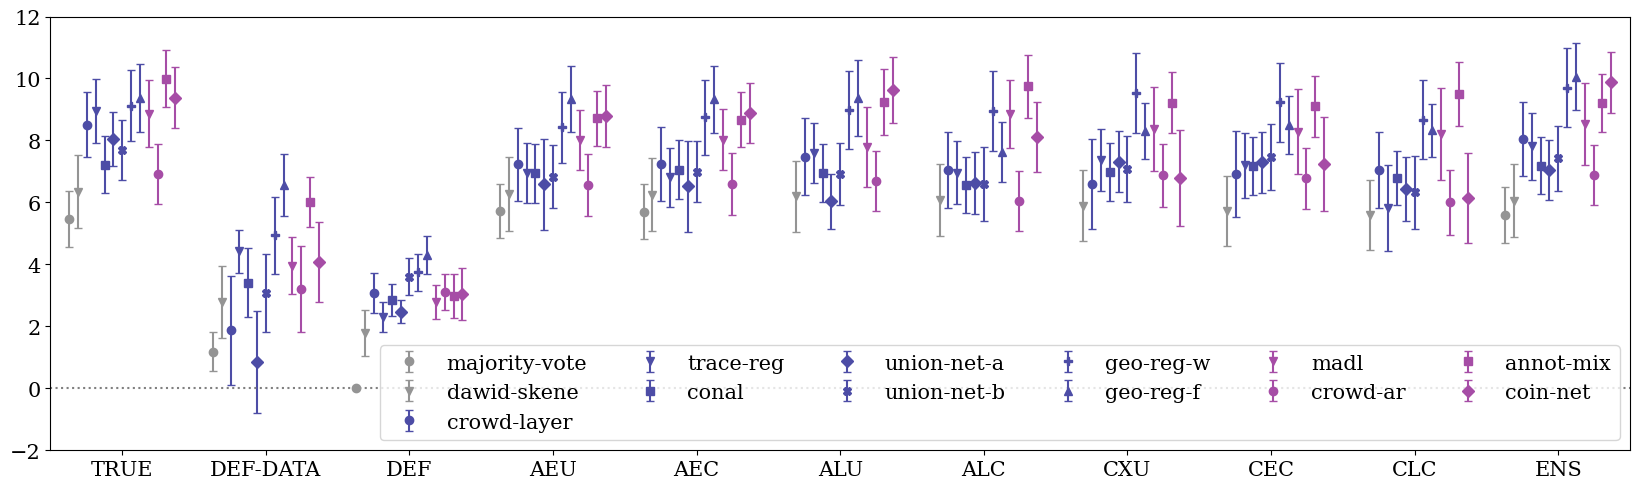

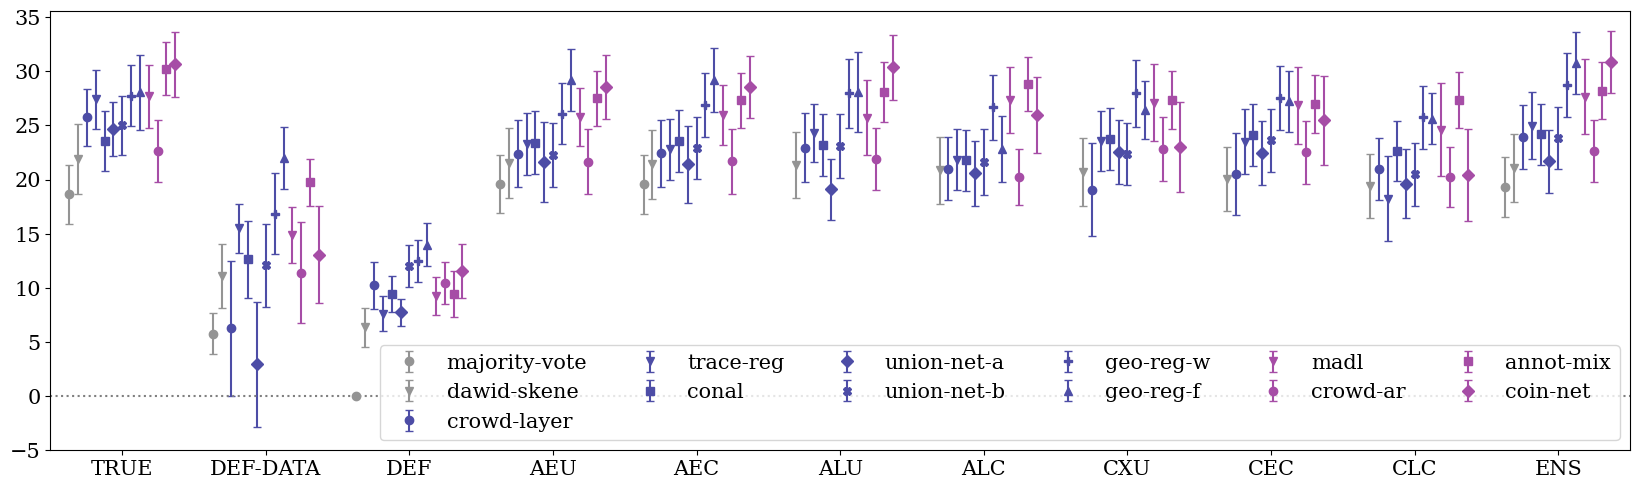

In [10]:
for scatter_type in ["absolute", "relative"]: 
    # ------------------------------------------------------------------
    # SETTINGS
    # ------------------------------------------------------------------
    approaches      = APPROACHES[1:]
    baseline        = "majority-vote"
    comp_approaches = approaches
    criteria        = list(subsets.keys())
    criteria.insert(1, "DEF-DATA")
    criteria.insert(2, "DEF")
    # print(criteria)

    # ------------------------------------------------------------------
    # 1 · COLLECT GAPS PER GROUP
    # ------------------------------------------------------------------
    abs_by_group = {}   # {group: {approach: [gaps]}}
    rel_by_group = {}   # same for % gaps

    for ds_name, df in df_dict.items():
        # sub: DataFrame whose *rows are groups* and columns are the approaches
        sub = df["mean"][criteria].T[approaches]
        base_val = sub["majority-vote"]["DEF"]

        for group_name, row in sub.iterrows():
            #base_val = row[baseline]
            if pd.isnull(base_val):
                continue

            # make sure the inner dicts exist
            abs_by_group.setdefault(group_name, {a: [] for a in comp_approaches})
            rel_by_group.setdefault(group_name, {a: [] for a in comp_approaches})

            for a in comp_approaches:
                val = row[a]
                if pd.notnull(val):
                    gap     = base_val - val                      # +ve ⇒ better than DEF
                    gap_pct = (gap / base_val) * 100
                    abs_by_group[group_name][a].append(gap)
                    rel_by_group[group_name][a].append(gap_pct)

    # ------------------------------------------------------------------
    # 2 · BUILD SUMMARY TABLE  (mean ± SD)
    # ------------------------------------------------------------------
    rows = []
    for group in sorted(abs_by_group):                      # one row per group
        row_dict = {"group": group}
        for a in comp_approaches:
            abs_vals = abs_by_group[group][a]
            rel_vals = rel_by_group[group][a]

            # If the group lacks observations for an approach, fill with NaN
            if abs_vals:
                abs_mean = np.mean(abs_vals)
                abs_sd   = np.std(abs_vals, ddof=1) / len(abs_vals)
                rel_mean = np.mean(rel_vals)
                rel_sd   = np.std(rel_vals, ddof=1) / len(abs_vals)
            else:
                abs_mean = abs_sd = rel_mean = rel_sd = np.nan

            # column names like "AEU_abs_mean", "AEU_abs_sd", ...
            row_dict[f"{a}_abs_m"] = abs_mean
            row_dict[f"{a}_abs_s"]   = abs_sd
            row_dict[f"{a}_rel_m"] = rel_mean
            row_dict[f"{a}_rel_s"]   = rel_sd

        rows.append(row_dict)

    summary_df = pd.DataFrame(rows)

    # nicer column order: group first, then each approach’s stats
    ordered_cols = (
        ["group"] +
        [f"{a}_{suffix}"
         for a in comp_approaches
         for suffix in ("abs_m", "abs_s", "rel_m", "rel_s")]
    )
    summary_df = summary_df[ordered_cols]

    # ------------------------------------------------------------------
    # 3 · DISPLAY OR SAVE
    # ------------------------------------------------------------------
    pd.set_option("display.float_format", "{:,.4f}".format)
    #print(summary_df.to_markdown(tablefmt="github", floatfmt=".2f"))            # to screen



    # ------------------------------------------------------------------
    # 4 · COLLAPSE mean & sd  →  "$μ_{\pm σ}$"
    # ------------------------------------------------------------------
    def make_cell(mu, sd):
        if np.isnan(mu) or np.isnan(sd):
            return "--"
        if mu > 0:
            return fr"$+{mu:.4f}_{{\pm {sd:.4f}}}$"
        else:
            return fr"${mu:.4f}_{{\pm {sd:.4f}}}$"

    # If they don’t, raise a gentle error.
    if 'abs_by_group' not in globals():
        raise NameError("`abs_by_group` not found – run the gap‑collection cell first.")

    categories      = abs_by_group.keys()        # 12 categorical groups
    n_groups        = len(categories)
    n_approaches    = len(comp_approaches)

    x_base          = np.arange(n_groups)                # positions on x‑axis
    offset          = 0.8 / n_approaches                  # spread approaches across the group slot
    markers         = ["o", "v", "s"]#, "^", "v", "P", "X"] # enough unique markers
    legend = {
        "majority-vote": ["o", "#949494ff"],
        "dawid-skene": ["v", "#949494ff"],

        "crowd-layer": ["o", "#4d4da6ff"],
        "trace-reg": ["v", "#4d4da6ff"],
        "conal": ["s", "#4d4da6ff"],
        "union-net-a": ["D", "#4d4da6ff"],
        "union-net-b": ["X", "#4d4da6ff"],
        "geo-reg-w": ["P", "#4d4da6ff"],
        "geo-reg-f": ["^", "#4d4da6ff"],

        "crowd-ar": ["o", "#a64da6ff"],
        "madl": ["v", "#a64da6ff"],
        "annot-mix": ["s", "#a64da6ff"],
        "coin-net": ["D", "#a64da6ff"],
    }


    plt.figure(figsize=(max(6, n_groups * 1.5), 5))

    for idx, approach in enumerate(comp_approaches):
        means, ses = [], []
        for g in ordered_criteria:
            if scatter_type == "relative":
                vals = rel_by_group[g][approach]
                yticks = np.arange(-5, 40, 5)
            else:
                vals = abs_by_group[g][approach]
                yticks = np.arange(-2, 14, 2)
            if vals:
                means.append(np.mean(vals))
                ses.append(np.std(vals, ddof=1) / np.sqrt(len(vals)))
            else:
                means.append(np.nan)
                ses.append(np.nan)

        # x positions shifted per approach
        x_pos = x_base - 0.4 + offset/2 + idx * offset
        plt.errorbar(x_pos, means, yerr=ses, fmt=legend[approach][0], color=legend[approach][1],
                     capsize=3, label=approach, linestyle='None')

    # Aesthetics
    plt.axhline(0, color='grey', linestyle=':')
    plt.xlim(-0.5, n_groups-0.5)
    plt.xticks(x_base, categories, ha='center', fontsize=15)
    plt.yticks(yticks, fontsize=15)
    plt.legend(ncol=min(n_approaches, 6), fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f"approaches_{scatter_type}_diff_per_criterion.pdf"))
    plt.show()

## Computation Times

Given an AMD Ryzen 9 7950X as CPU, the sum of training times for the LFC approach coin with its default HPC and the times for computing all empirical risks to evalaute the HPS criterion ENS are reported in seconds across a $K=5$-fold cross validation for the dataset variant `dopanim-full`.

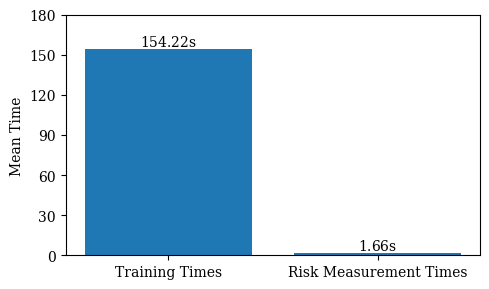

In [11]:
# Measured in separate experiments on a local work station.
training_times = np.array([154.3700, 153.3405, 154.2420, 154.5105, 154.6445])
risk_measurement_times = np.array([1.7215, 1.6655, 1.6910, 1.6225, 1.6180])

# Calculate means
means = [training_times.mean(), risk_measurement_times.mean()]
x_labels = ['Training Times', 'Risk Measurement Times']

# Create vertical bar plot
fig, ax = plt.subplots(figsize=(5, 3))
x_pos = range(len(x_labels))
ax.bar(x_pos, means)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_yticks(np.arange(0, 200, 30))
ax.set_ylabel('Mean Time')

# Annotate bars with mean values
for i, v in enumerate(means):
    ax.text(i, v, f'${v:.2f}$s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "computation_time_comparison.pdf"))
plt.show()